<a href="https://colab.research.google.com/github/ayaanle-hashi/telecom-churn/blob/master/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import imblearn
import warnings
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,average_precision_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve,auc,confusion_matrix
from sklearn.model_selection import train_test_split,KFold
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import skew
from sklearn.model_selection import cross_val_score,cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE


warnings.filterwarnings('ignore')


plt.style.use('ggplot')


columns = ['state','account_length','area_code','phone_number','international_plan','voice_mail_plan',
'number_voice_mail_message','total_day_mins','total_day_calls','total_day_charge','total_eve_mins',
'total_eve_calls','total_eve_charge','total_night_mins','total_night_calls','total_night_charge','total_intl_mins',
'total_intl_calls','total_intl_charge','number_customer_service_calls','churn']


training_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1yaLz9DshIRhJNpVeGjoeLJApYhBU7vl4hgj52eEQ2tc/export?format=csv&id=1yaLz9DshIRhJNpVeGjoeLJApYhBU7vl4hgj52eEQ2tc&gid=1213731184",names=columns,skipinitialspace=True)

testing_df = pd.read_csv("https://docs.google.com/spreadsheets/d/13T6xPPbp9iuFSxIblAhR7eMJSPbwHyBkebLyBYm2aJ0/export?format=csv&id=13T6xPPbp9iuFSxIblAhR7eMJSPbwHyBkebLyBYm2aJ0&gid=1960079653",names=columns,skipinitialspace=True)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Preprocessing Data

Before we view the patterns within the dataset we need to clean the data.

In [ ]:
def binary_preprocess(x):
    if x == 'yes':
        return 1
    else:
        return 0

def churn_preprocess(x):
    if x == 'True.':
        return 1
    else:
        return 0

training_df['voice_mail_plan'] = training_df['voice_mail_plan'].apply(binary_preprocess)
training_df['international_plan'] = training_df['international_plan'].apply(binary_preprocess)
training_df['churn'] = training_df['churn'].apply(churn_preprocess)
training_df  = training_df.drop(['state','area_code'],axis=1)

testing_df['voice_mail_plan'] = testing_df['voice_mail_plan'].apply(binary_preprocess)
testing_df['international_plan'] = testing_df['international_plan'].apply(binary_preprocess)
testing_df['churn'] = testing_df['churn'].apply(churn_preprocess)
testing_df = testing_df.drop(['state','area_code'],axis=1)


# Inital Look

In [ ]:
training_df.describe()

account_length  ...        churn
count     3333.000000  ...  3333.000000
mean       101.064806  ...     0.144914
std         39.822106  ...     0.352067
min          1.000000  ...     0.000000
25%         74.000000  ...     0.000000
50%        101.000000  ...     0.000000
75%        127.000000  ...     0.000000
max        243.000000  ...     1.000000

[8 rows x 18 columns]

Intl features differ from the rest perhaps this was log transformed?

The churn rate within all the datapoints of the dataset is 14%

Lets have a look at the pairwise relationships between the features.

## Pairplots



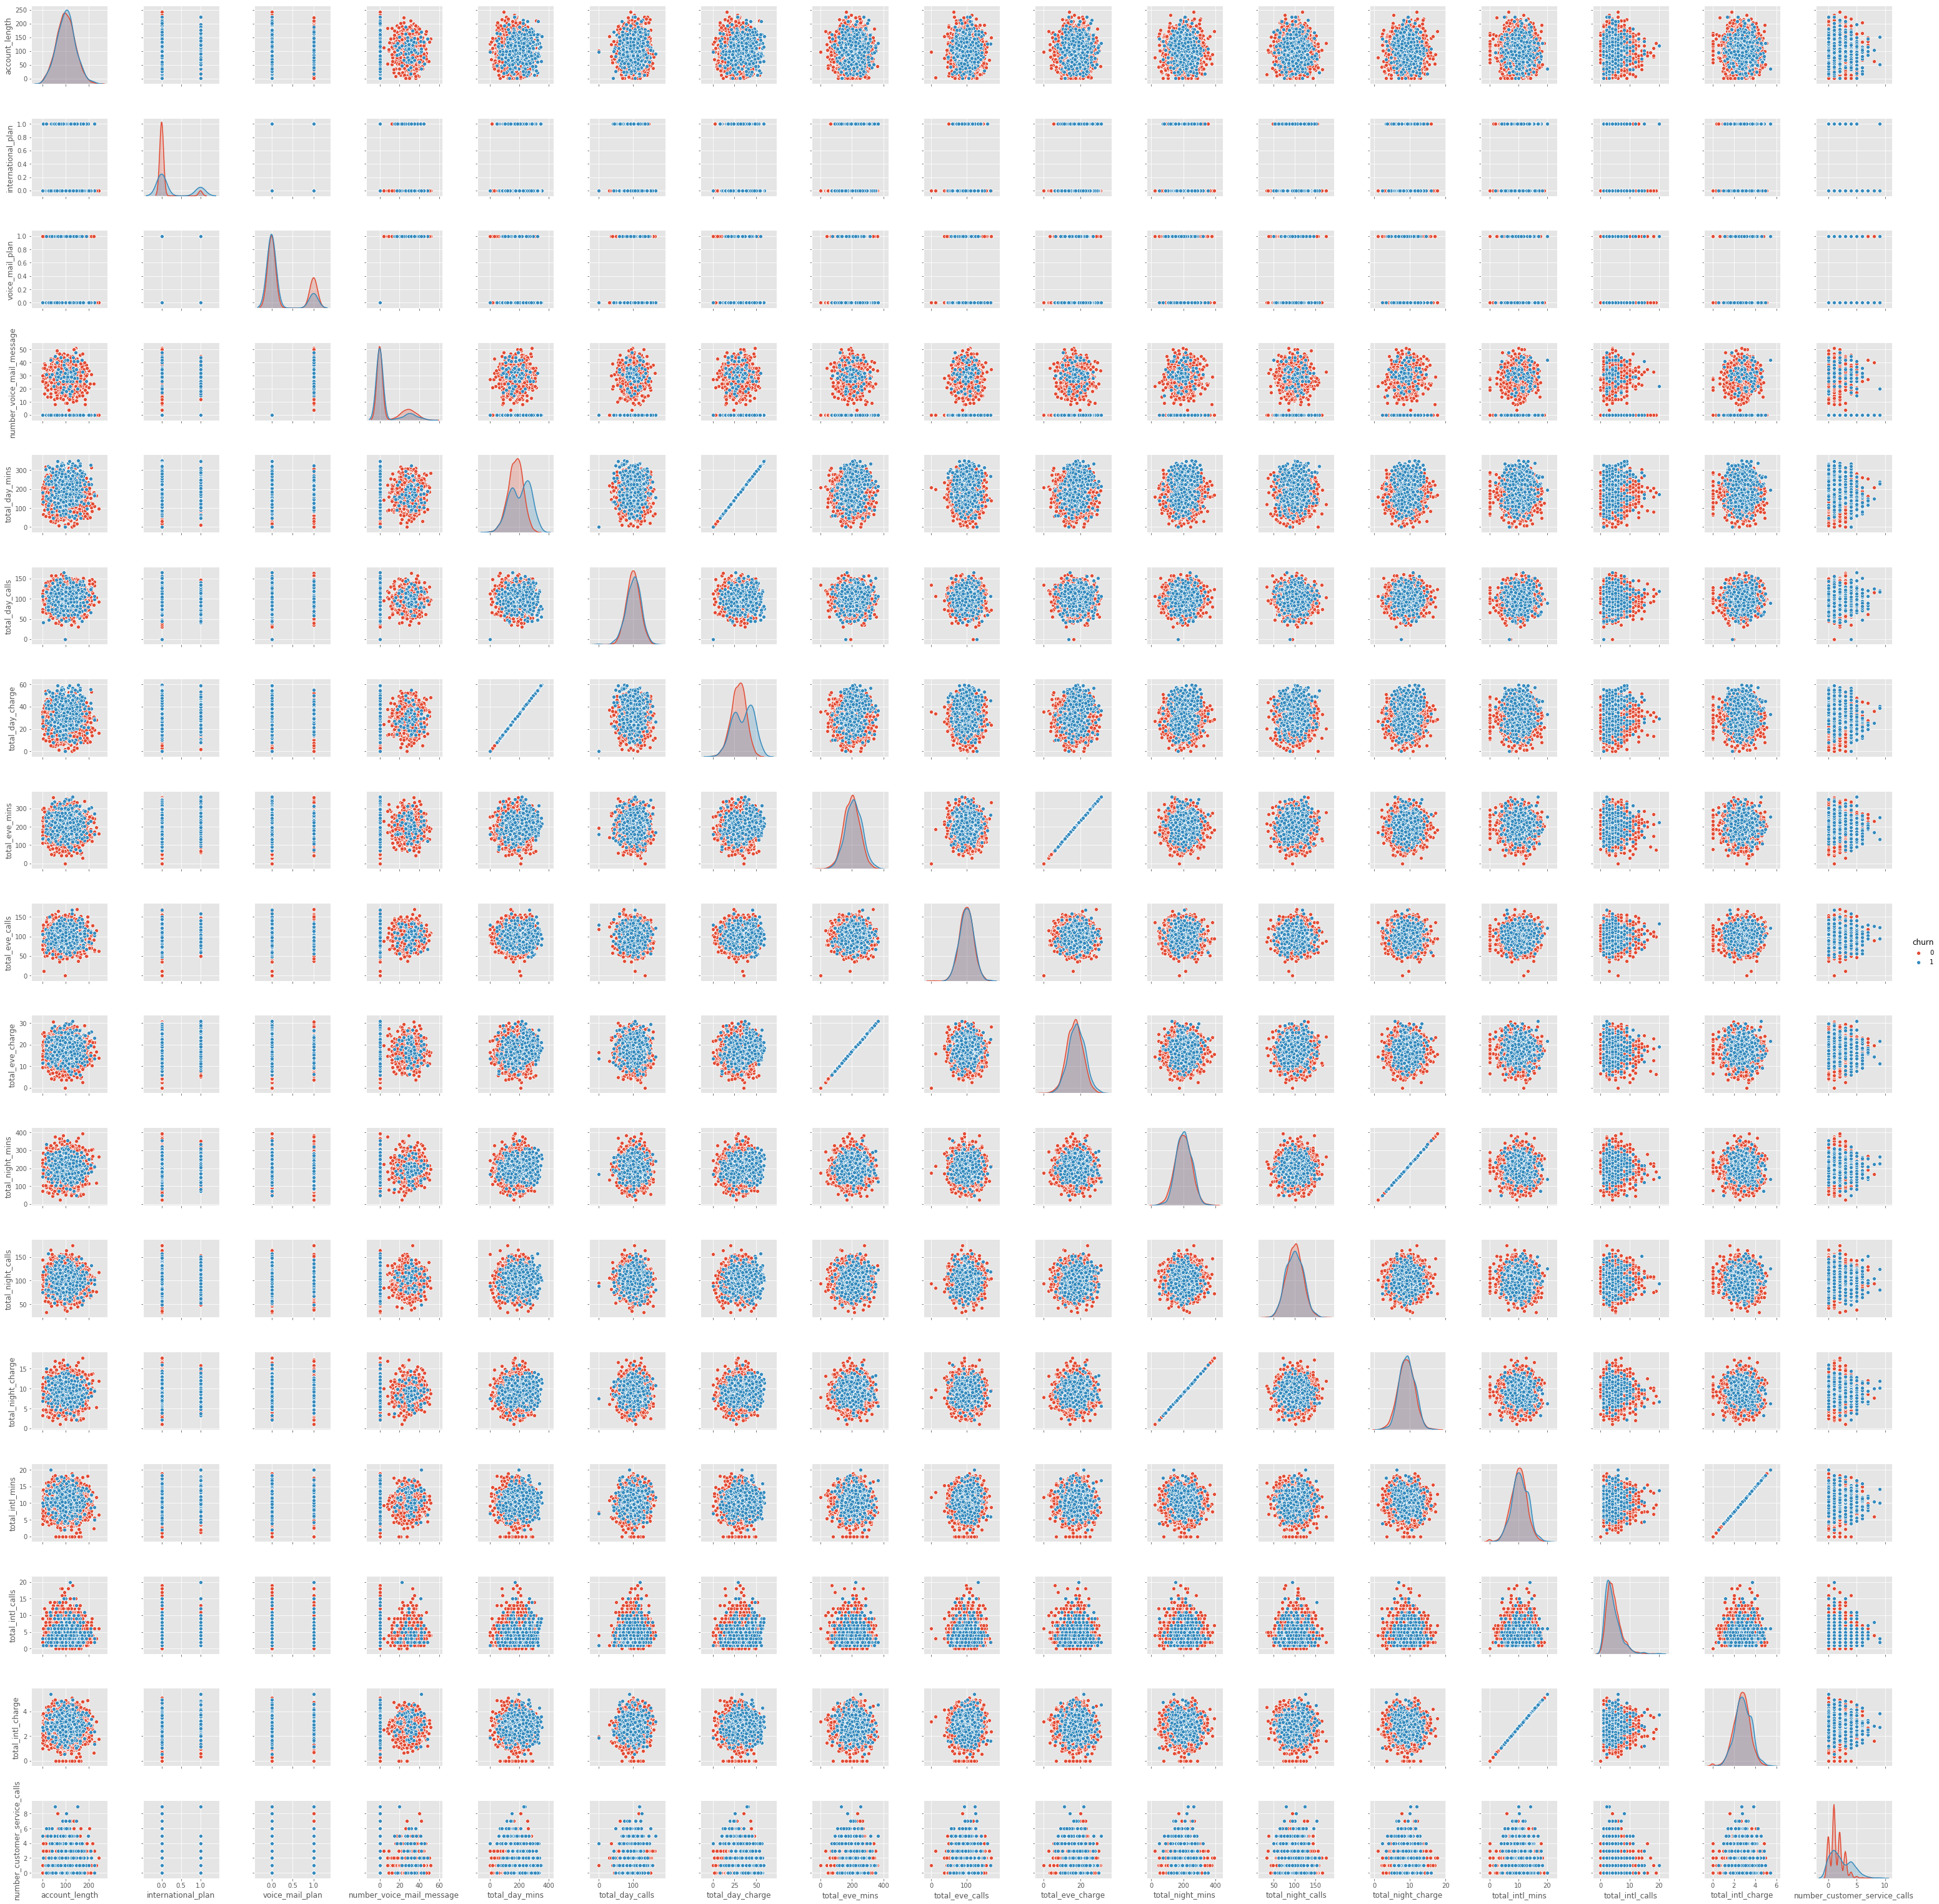

In [ ]:
plot_columns = list(training_df)

pairplot_columns = [col for col in plot_columns if col not in ('churn','state','area_code','phone_number')]

sns.pairplot(training_df,vars = pairplot_columns,hue='churn')

plt.show()

Infering from  the plots we can observe features that immediately stand out.  

There is a strong positive correlation between charges and total_mins for all types of day,night and intl. We can calculate the rate that  calls were charged at using these two features.

Also from  the kde plot distributions of  international_plan, total_day_charge,voice_mail_plan,number_customer_service_calls we can see a clear difference between the distributions of the classes. Lets have a further look into why this might be.

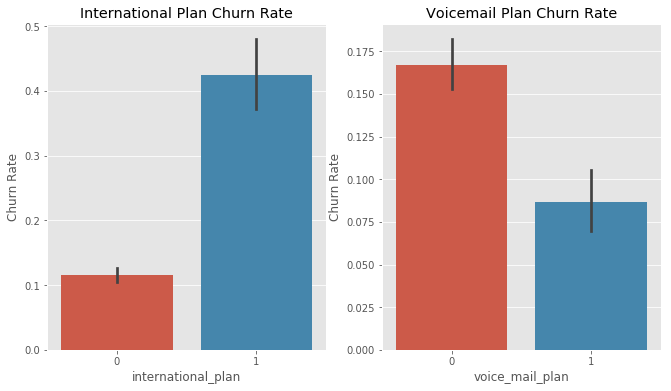

In [ ]:
plt.figure(figsize=(11, 6))


plt.subplot(1, 2, 1)

sns.barplot(x='international_plan', y='churn', data=training_df)

plt.title("International Plan Churn Rate")

plt.ylabel("Churn Rate")


plt.subplot(1, 2, 2)

sns.barplot(x='voice_mail_plan', y='churn', data=training_df)

plt.title("Voicemail Plan Churn Rate")

plt.ylabel("Churn Rate")


plt.show()

# **International Plan and Voice Mail Plan**

## **International Plan**

Viewing these barplots we can see that the average churn rate for a customer who has an international plan is  42% and a customer who does not have one has a churn rate of 11%

This could be because of higher charges for the companys international rates. And perhaps people who call internationally frequently would be on the lookout for better offers from competitors.

We could run an experiment on people who are likely to churn and split them into treatment and control groups and  give the treatment a discounted rate and see if this leads to an significant difference in retention rates between the two groups.


## **Voicemail Plan**


Customers who have a voicemail plan tend churn at an average rate of 8% where as someone who does not have a voicemail plan tends to churn at an average rate of 17%. This makes sense as people who receive voicemails are more likely to use the service and use the phone for important matters. We could set up a campaign advertising the voicemail plan.

# **Customer Service Calls**

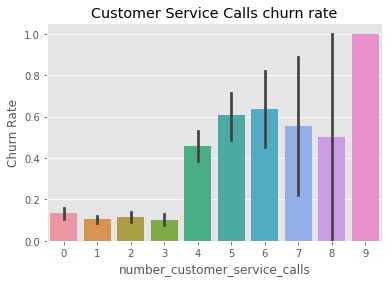

In [ ]:
sns.barplot(x='number_customer_service_calls',y='churn',data=training_df)

plt.title("Customer Service Calls churn rate")

plt.ylabel("Churn Rate")

plt.show()

## **Does poor customer service lead to churn?**

The plot shows a clear trend of customers churning with increasing number of customer service calls being made.

Between 1-3 calls there is a similar rate of churn of around 10%. This increases by over 30% when customers start making 4 calls or more.

The company needs to ask itself why customers are calling in so often.

I suggest feedback to be asked from customers at the end of calls and customer service training for employees to be able to deal with issues efficently.

We can create a binary feature from observing the distribution for example high_number_of_customer_service_calls (>3).



# **Observing Continous Variables**

Lets see if there any patterns that stand out in the distributions of the the continous variables

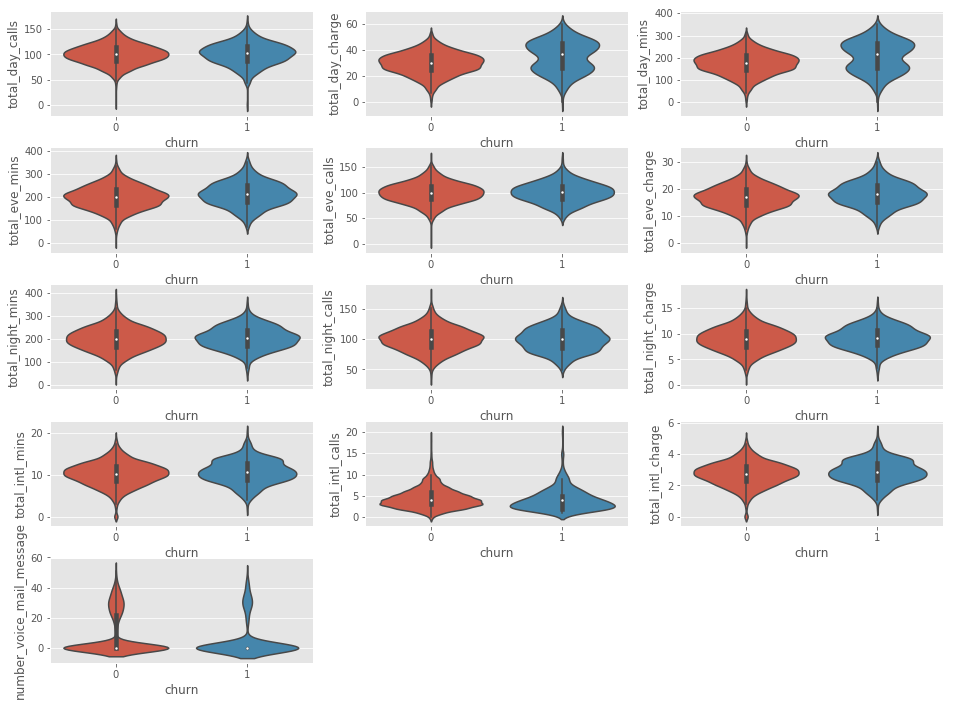

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(['total_day_calls','total_day_charge','total_day_mins','total_eve_mins',
'total_eve_calls','total_eve_charge','total_night_mins','total_night_calls','total_night_charge','total_intl_mins',
'total_intl_calls','total_intl_charge','number_voice_mail_message']):
  
    plt.subplot(5, 3, i + 1)
    
    sns.violinplot (x=training_df['churn'], y=training_df[col])
    
    plt.subplots_adjust(hspace = 0.3)




## **Analysis of violin plots**

For most the features we can see no striking differences between the distributions of customers who churn and dont churn.

However for total day mins and total day charge the customers who churn have a bimodial distribution suggesting they are more likely to churn at different charges perhaps this relates to some sort of price hike that the company has introduced in the past.

The median of churned customers is slightly higher for both total day charge and 
total day mins. 

Which makes sense higher prices would lead to unhappy customers.

We can create a binary feature to indicate a certain threshold for these features to ensure the model learns this pattern implicitly.

## **Outliers**

It is important to understand if there are any outliers within the continous variables to determine if they should be removed to prevent overfitting or to retain them.

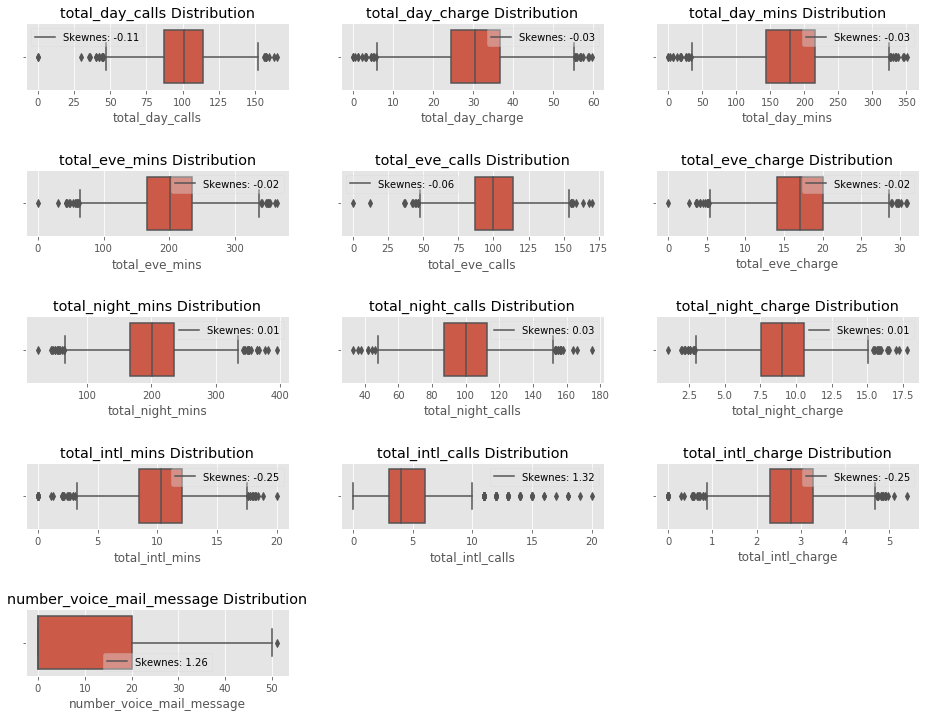

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(['total_day_calls','total_day_charge','total_day_mins','total_eve_mins',
'total_eve_calls','total_eve_charge','total_night_mins','total_night_calls','total_night_charge','total_intl_mins',
'total_intl_calls','total_intl_charge','number_voice_mail_message']):
  
    plt.subplot(5, 3, i + 1)
    
    sns.boxplot(x=training_df[col])

    skewness = training_df[col].skew()
    plt.title("{} Distribution".format(col))
    plt.legend(["Skewnes: {}".format(round(skewness,2))],framealpha=0.4)
    plt.subplots_adjust(hspace = 1.2)

## **Skewness**


A majority of the features have little skew however number_voice_mail_message and total_intl_calls distribution both are skewed to right.  In this case because we have a small amount of datapoints within the dataset i will not remove outliers as this will mean loss in vital information.

# **Baseline Model**

I decided to use a decision tree as a baseline to see how the raw dataset without any feature engineering performs.

In [ ]:
baseline_train_df = training_df.copy()

X_train = baseline_train_df.drop(['churn','phone_number'],axis = 1)

y_train = baseline_train_df.churn


baseline_test_df = testing_df.copy()

X_test = baseline_test_df.drop(['churn','phone_number'],axis = 1)

y_test = baseline_test_df.churn


tree = DecisionTreeClassifier()

tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test,y_pred) * 100

print(f"The accuracy for the baseline model is {round(accuracy,2)} %")

The accuracy for the baseline model is 92.32 %


### **Accuracy of Baseline**

An accuracy of 91% wow! this must be a very good machine learning model right?

The accuracy is hiding something.

Lets have a look at the confusion matrix.

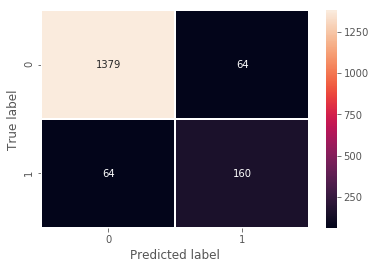

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred,labels=[0,1]), annot=True, fmt="d", linewidths=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

We can see quite a few false negatives and false positives. 

Actually 29% of the positive class was incorrectly classified in the testing dataset.

And 6% of the negative class was incorrectly classified.

Both can become incredibely costly for any company trying to use this model to retain customers

Lets view the distribution of the target variable in the datasets.

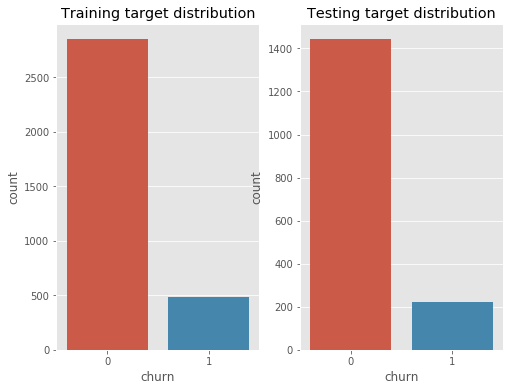

In [ ]:
plt.figure(figsize=(8, 6))


plt.subplot(1, 2, 1)

sns.countplot(x=training_df['churn'])

plt.title("Training target distribution")


plt.subplot(1, 2, 2)

sns.countplot(x=testing_df['churn'])

plt.title("Testing target distribution")


plt.show()

There is a clear imbalance. The training dataset has an imbalance of 6:1 whereas the testing dataset has an imbalance of 7:1

Accuracy is not the right metric to use in this scenario lets use some other metrics.

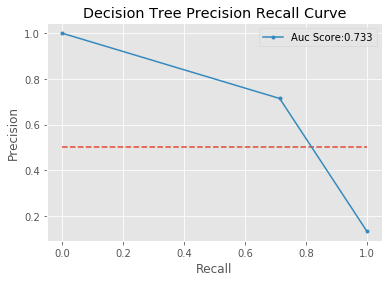

The f1 score for the baseline model is 0.7142857142857143, Precision: 0.7142857142857143, Recall: 0.7142857142857143


In [ ]:

proba_tree = tree.predict_proba(X_test)

probs_tree = proba_tree[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs_tree)

auc_score = auc(recall, precision)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')

plt.plot(recall, precision, marker='.',label="Auc Score:{}".format(round(auc_score,3)))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Decision Tree Precision Recall Curve")
plt.legend(loc='best')
plt.show()


print(f"The f1 score for the baseline model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")

 I think we can improve upon this especially in precision as having high false positives would mean we potentially reach out to customers who would not churn and this could be costly for the use case of this model.


# **Dealing with Imbalance**


Lets explore a few ways to deal with this imbalance.

### **Undersampling**

First lets try undersampling the majority class.

In [ ]:
rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_train, y_train)

tree = DecisionTreeClassifier()

tree.fit(X_res,y_res)

y_pred = tree.predict(X_test)


f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

print(f"The f1 score for the baseline model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")



The f1 score for the baseline model is 0.5329428989751098, Precision: 0.39651416122004357, Recall: 0.8125


A slight improvement once we balanced the classes. 

Lets see if oversampling the minority class leads to an improvement.

## **Oversampling**


In [ ]:
smote_sample = SMOTE(random_state=42)

X_res, y_res = smote_sample.fit_resample(X_train, y_train)

tree = DecisionTreeClassifier()

tree.fit(X_res,y_res)

y_pred = tree.predict(X_test)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

print(f"The f1 score for the baseline model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")



The f1 score for the baseline model is 0.6849894291754757, Precision: 0.6506024096385542, Recall: 0.7232142857142857


This is less effective than undersampling and just modelling with the original classes. This is because the model is learning noise as the minority classes is trying to be syntethically created to match over 2600 negative samples.

Lets try combining both methods.

## **Combination of Undersampling and Oversampling**



In [ ]:
smoteenn_sample = SMOTEENN(random_state=42)

X_res, y_res = smoteenn_sample.fit_resample(X_train, y_train)

tree = DecisionTreeClassifier()

tree.fit(X_res,y_res)

y_pred = tree.predict(X_test)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

print(f"The f1 score for the baseline model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")


The f1 score for the baseline model is 0.6451612903225805, Precision: 0.5610561056105611, Recall: 0.7589285714285714


None of these methods produce a breakthrough lets try to generate some features and use more powerful algorithms.

# **Feature Generation**

In [ ]:
def feature_generation(df):
    
    df['day_rate'] = round(df['total_day_charge'] / df['total_day_mins'],2)
    df['avg_secs_per_day_call'] = round(df['total_day_calls'] / df['total_day_mins'],2) * 60
    df['eve_rate'] = round(df['total_eve_charge'] / df['total_eve_mins'],2)
    df['avg_secs_per_eve_call'] = round(df['total_eve_calls'] / df['total_eve_mins'],2) * 60
    df['night_rate'] = round(df['total_night_charge'] / df['total_night_mins'],2)
    df['avg_secs_per_night_call'] = round(df['total_night_calls'] / df['total_night_mins'],2) * 60
    df['intl_rate'] = round(df['total_intl_charge'] / df['total_intl_mins'],2)
    df['avg_secs_per_intl_call'] = round(df['total_intl_calls'] / df['total_intl_mins'],2) * 60
    df['high_number_of_customer_service_calls'] = df['number_customer_service_calls'].apply(lambda x: 1 if x > 3 else 0)
    df['high_day_charge'] = df['total_day_charge'].apply(lambda x: 1 if x > 43 else 0 )
    
    
    
    return df
  
training_df = feature_generation(training_df)

testing_df = feature_generation(testing_df)

Now that we have created some features lets try to run some statistical tests to determine if all these are important in predicting churn.

# Statistical Tests

### **Chi Square**

In [ ]:
 def chisquaretest(df,col,target, alpha=0.05):
        X = df[col].astype(str)
        Y = df[target].astype(str)
        
        observed = pd.crosstab(Y,X) 
        
        chi2, p, dof, expected = stats.chi2_contingency(observed.values)
     
        if  p < alpha:
            print(f"{col} is IMPORTANT for Prediction")
        else:
            print(f"{col} is NOT an important predictor. (Discard {col} from dataset)")
            
columns = ['day_rate','night_rate','intl_rate',
           'eve_rate','international_plan'
          ,'voice_mail_plan'] 

for col in columns:
    chisquaretest(training_df,col,'churn')

day_rate is NOT an important predictor. (Discard day_rate from dataset)
night_rate is NOT an important predictor. (Discard night_rate from dataset)
intl_rate is NOT an important predictor. (Discard intl_rate from dataset)
eve_rate is NOT an important predictor. (Discard eve_rate from dataset)
international_plan is IMPORTANT for Prediction
voice_mail_plan is IMPORTANT for Prediction


The chi square test determined that  the rate features are not important. However through experimentation inlcluding intl rates and day rates the model performed better. 

Lets start comparing more powerful algorithms to see if they increase predictive power



# Model Comparison

In [ ]:

training_df = training_df.dropna(how='any',axis=0) 

training_df = training_df.drop(['night_rate','eve_rate','phone_number'],axis=1)

testing_df = testing_df.dropna(how='any',axis=0) 

# Creating the dataframe for the output of the model

output_df = testing_df.copy()

testing_df = testing_df.drop(['night_rate','eve_rate','phone_number'],axis=1)


# Fitting and comparing models

X_train = training_df.drop('churn',axis = 1)

y_train = training_df.churn

scoring = ['precision', 'recall', 'f1']

models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))

results=[]
names = []

for name, model in tqdm(models):
  kfold = KFold(n_splits=5, random_state=42)
  cv_results = cross_validate(model, X_train, y_train, cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}, {cv_results['test_recall'].mean()},{cv_results['test_precision'].mean()},{cv_results['test_f1'].mean()}")


 33%|███▎      | 1/3 [00:00<00:00,  2.72it/s]

RF, 0.6929445240975337,0.8970595696584397,0.7816927342279686


 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

ADA, 0.38566614649434106,0.6074669954381566,0.46822807548536527


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

XGB, 0.6999558570710901,0.9337754254877542,0.7999476167526574


Surprise Surprise the winner is XGboost

Lets tune the hyperparmetrs and test on the test dataset.

# XGBoost




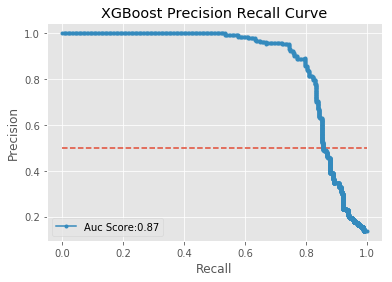

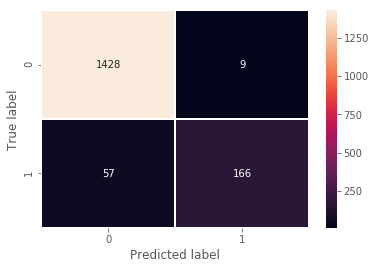

The f1 score for the XGBoost model is 0.8341708542713567, Precision: 0.9485714285714286, Recall: 0.7443946188340808


In [ ]:
# Hyperparameters tuned using 4-fold CV 

xgb = XGBClassifier(colsample_bytree = 0.9, gamma = 0.82, learning_rate =0.1, 
                    max_depth = 9, min_child_weight = 3)


xgb.fit(X_train,y_train)

X_test = testing_df.drop('churn',axis = 1)

y_test = testing_df.churn

y_pred = xgb.predict(X_test)

proba_tree = xgb.predict_proba(X_test)

probs_tree = proba_tree[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs_tree)

auc_score = auc(recall, precision)

f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')

plt.plot(recall, precision, marker='.',label="Auc Score:{}".format(round(auc_score,3)))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision Recall Curve")
plt.legend(loc='best')
plt.show()

sns.heatmap(confusion_matrix(y_test,y_pred,labels=[0,1]), annot=True, fmt="d", linewidths=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

print(f"The f1 score for the XGBoost model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")

As expected XGBoost with tuned hyperparametres performed the best. 

The model now  misclassifed the positive class at 25%.

And the model only misclassifed the negative class at 0.6% !

These improvements are critical to retaining customers especially with such a high precision we will have few false positives.

We are left with a model that has a F1 score of 0.83, Precision of 0.94 and Recall of 0.74. I can trust the output of this model to correctly predict customers who are likely to churn.

Lets have a look at some of the most important features

# Feature Importance

In [ ]:

feature_importances = pd.DataFrame(xgb.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances.head(20))

# Dataframe output containing number and churn probablity of customers

output_df['churn_probability'] = xgb.predict_proba(X_test)[:,1] * 100

output_df = output_df.sort_values(by='churn_probability',ascending=False)

output_df = output_df[['phone_number', 'churn_probability']].copy()

output_df.head()

                                       importance
high_number_of_customer_service_calls    0.119546
high_day_charge                          0.117345
international_plan                       0.100176
total_intl_charge                        0.071613
number_customer_service_calls            0.071051
voice_mail_plan                          0.068242
total_day_charge                         0.065339
total_intl_calls                         0.057262
total_day_mins                           0.051532
total_eve_charge                         0.036544
total_intl_mins                          0.032923
total_eve_mins                           0.032585
number_voice_mail_message                0.029476
avg_secs_per_intl_call                   0.027965
total_night_mins                         0.016128
avg_secs_per_day_call                    0.015743
total_night_charge                       0.014468
avg_secs_per_night_call                  0.013490
avg_secs_per_eve_call                    0.013477


phone_number  churn_probability
1180     398-8927          99.731812
633      383-2254          99.660751
1620     358-4500          99.621307
1377     345-4482          99.542023
931      414-5554          99.534599

Thats not the end of the experimentation.

Lets see if a neural network performs any better.

# Neural Network

W0615 13:56:06.334578 140349333710720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0615 13:56:06.470020 140349333710720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The f1 score for the Neural Network model is 0.7058823529411765, Precision: 0.8214285714285714, Recall: 0.6188340807174888


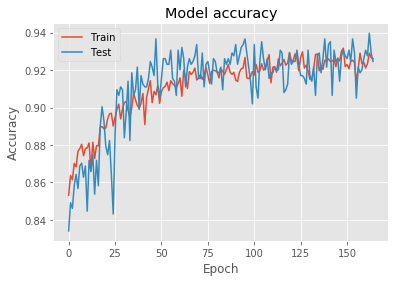

In [ ]:
input_dim = X_train.shape[1]


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(500, input_dim=input_dim,kernel_initializer='uniform',activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(250, input_dim=input_dim,kernel_initializer='uniform',activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, input_dim=input_dim,kernel_initializer='uniform',activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1,kernel_initializer='uniform',activation=tf.nn.sigmoid))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=165,validation_split=0.2,verbose=0,shuffle=True)


y_pred = model.predict_classes(X_test)


f1_scorer = f1_score(y_test,y_pred)
precision_scorer = precision_score(y_test,y_pred)
recall_scorer = recall_score(y_test,y_pred)


print(f"The f1 score for the Neural Network model is {f1_scorer}, Precision: {precision_scorer}, Recall: {recall_scorer}")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()




Unfortunately the neural network did not provide any extra predictive power in this case.

# Conclusion

There were a few driving factors of churn that i discovered through explatory data analysis. I noticed that there was a significant difference between the distributions of the classes so i created binary threshold features for total day charge and number of customer of service calls.

These features ended up being essential to predictive power. Also there seems to be a strong correlation between customers who have an international plan and churn.

Customers who have a voicemail plan tend to churn at a lower rate of 8% compared to 17% for customers without. I would recommend a campaign advertising the voicemail plan to keep customers engaged.

I would suggest that the company uses the output of the machine learning model to perform  an a/b/c test experiment to determine if a discount in day rates or intl rates would lead to an increase in retention rates and to what extent.

The decision tree classifer incorrectly predicted churn for 6% of customers who would not churn. The XGBoost classifer did this less than 0.6% of the time.

As the machine learning model has high precision i am confident in its ability to recognise customers who would most likely benefit from such a discount and prevent churn.

The recall is relatively high aswell  we would pick up relevant customers 74% of the time. That could save alot of money for the company

I would also suggest to train customer service employess to be able to efficently deal with queries from customers as this was an important predictor for churn aswell. 